# Cell 1: Calculating Technical Indicators

In [4]:
import pandas as pd
import numpy as np
import warnings

# Suppress RuntimeWarnings for cleaner output
warnings.filterwarnings("ignore", category=RuntimeWarning)

# --- Load preprocessed dataset ---
data_path = "../data/processed/nifty50_cleaned.csv"  # adjust if different
df = pd.read_csv(data_path, parse_dates=["Date"])

# Ensure sorting (important for rolling calculations)
df = df.sort_values(by=["Company", "Date"]).reset_index(drop=True)

# --- Function to calculate indicators for a company ---
def calculate_indicators(df, company):
    company_df = df[df['Company'] == company].copy()
    company_df['Close'] = pd.to_numeric(company_df['Close'], errors='coerce')
    company_df['Volume'] = pd.to_numeric(company_df['Volume'], errors='coerce')
    company_df = company_df.dropna(subset=['Close', 'Volume'])
    
    # --- SMA (Simple Moving Average) ---
    company_df['SMA_20'] = company_df['Close'].rolling(window=20).mean()
    
    # --- EMA (Exponential Moving Average) ---
    company_df['EMA_20'] = company_df['Close'].ewm(span=20, adjust=False).mean()
    
    # --- RSI (Relative Strength Index, 14 days) ---
    delta = company_df['Close'].diff()
    gain = delta.where(delta > 0, 0).rolling(window=14).mean()
    loss = (-delta.where(delta < 0, 0)).rolling(window=14).mean()
    rs = gain / loss
    company_df['RSI_14'] = 100 - (100 / (1 + rs))
    
    # --- Bollinger Bands (20-day) ---
    rolling_mean = company_df['Close'].rolling(window=20).mean()
    rolling_std = company_df['Close'].rolling(window=20).std()
    company_df['BB_upper'] = rolling_mean + 2 * rolling_std
    company_df['BB_lower'] = rolling_mean - 2 * rolling_std
    
    # --- Volume Indicators ---
    # On-Balance Volume (OBV)
    company_df['OBV'] = (np.sign(company_df['Close'].diff()) * company_df['Volume']).fillna(0).cumsum()
    
    # Volume Moving Average (20-day)
    company_df['VMA_20'] = company_df['Volume'].rolling(window=20).mean()
    
    return company_df

# --- Apply to all companies ---
companies = df['Company'].unique()
df_with_indicators = pd.concat([calculate_indicators(df, company) for company in companies])

# --- Save with indicators ---
output_path = "../data/processed/preprocessed_with_indicators.csv"
df_with_indicators.to_csv(output_path, index=False)

# --- Verify ---
print(f"Indicators calculated for {len(companies)} companies.")
print("Sample (first 5 rows with indicators):")
print(df_with_indicators.head())


Indicators calculated for 49 companies.
Sample (first 5 rows with indicators):
        Date     Company    Open   High     Low   Close   Volume  SMA_20  \
0 2016-01-01  ADANIPORTS  261.00  268.3  260.10  267.55  1347893     NaN   
1 2016-01-04  ADANIPORTS  264.45  266.5  257.00  257.95  2536252     NaN   
2 2016-01-05  ADANIPORTS  259.20  260.3  254.25  255.70  2815055     NaN   
3 2016-01-06  ADANIPORTS  253.00  257.3  250.55  251.80  2029467     NaN   
4 2016-01-07  ADANIPORTS  245.65  247.5  241.50  245.00  4244402     NaN   

       EMA_20  RSI_14  BB_upper  BB_lower         OBV  VMA_20  
0  267.550000     NaN       NaN       NaN         0.0     NaN  
1  266.635714     NaN       NaN       NaN  -2536252.0     NaN  
2  265.594218     NaN       NaN       NaN  -5351307.0     NaN  
3  264.280483     NaN       NaN       NaN  -7380774.0     NaN  
4  262.444246     NaN       NaN       NaN -11625176.0     NaN  


# Cell 2: Injection of Anomalies

In [30]:
# --- Anomaly Injection (3 per company) ---

import pandas as pd
import numpy as np
import random
import os

# Load preprocessed dataset with indicators
data_path = "../data/processed/preprocessed_with_indicators.csv"
df = pd.read_csv(data_path, parse_dates=["Date"])

# Add anomaly label column
df["Anomaly"] = 0  

# Set random seed for reproducibility
random.seed(42)

# Function to inject anomalies into one company's data
def inject_anomalies(company_df, n=10):
    n = min(n, len(company_df))
    idx_choices = random.sample(range(len(company_df)), n)
    for idx in idx_choices:
        # Randomly choose anomaly type
        anomaly_type = random.choice(["spike", "drop"])
        #anomaly_type = random.choice(["spike", "drop", "volume_spike"])
        if anomaly_type == "spike":
            company_df.iloc[idx, company_df.columns.get_loc("Close")] *= 1.5 # +50% spike
        elif anomaly_type == "drop":
            company_df.iloc[idx, company_df.columns.get_loc("Close")] *= 0.5  # -50% drop
        #elif anomaly_type == "volume_spike":
            #company_df.iloc[idx, company_df.columns.get_loc("Volume")] *= 8  # 8x volume
        company_df.iloc[idx, company_df.columns.get_loc("Anomaly")] = 1
    return company_df

# Apply anomaly injection per company
df_with_anomalies = df.groupby("Company", group_keys=False).apply(lambda x: inject_anomalies(x, n=10))

# Save the dataset
output_path = "../data/processed/nifty50_with_anomalies.csv"
os.makedirs(os.path.dirname(output_path), exist_ok=True)
df_with_anomalies.to_csv(output_path, index=False)

print(f"Anomaly injection complete! Saved to {output_path}")
print("Total anomalies injected:", df_with_anomalies['Anomaly'].sum())


/var/folders/0j/5jfmjxkn0mb132z0x6jk13xm0000gn/T/ipykernel_37523/1439151164.py:36: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df_with_anomalies = df.groupby("Company", group_keys=False).apply(lambda x: inject_anomalies(x, n=10))


Anomaly injection complete! Saved to ../data/processed/nifty50_with_anomalies.csv
Total anomalies injected: 490


# Cell 3: XGBoost Anomaly Detection

/opt/homebrew/lib/python3.11/site-packages/xgboost/training.py:183: UserWarning: [01:02:10] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


Total anomalies in train set: 338
Total anomalies in test set: 152
Evaluation - XGBoost (Threshold = 0.4)
Precision: 0.5570776255707762
Recall   : 0.8026315789473685
F1 Score : 0.6576819407008087

Classification Report:
              precision    recall  f1-score   support

           0       1.00      0.99      1.00     19223
           1       0.56      0.80      0.66       152

    accuracy                           0.99     19375
   macro avg       0.78      0.90      0.83     19375
weighted avg       0.99      0.99      0.99     19375



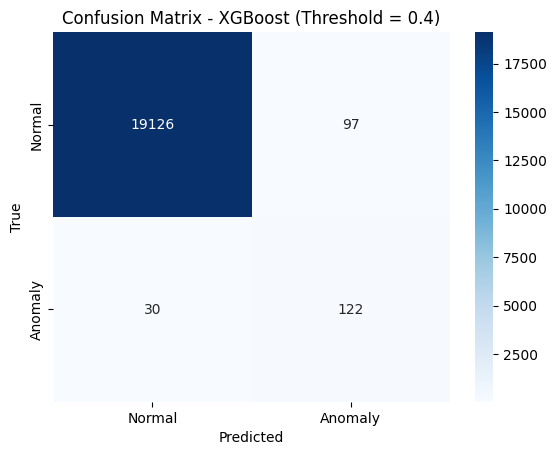

In [20]:
# --- XGBoost Anomaly Detection with Lowered Threshold ---
import pandas as pd
import numpy as np
import xgboost as xgb
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, classification_report
import matplotlib.pyplot as plt
import seaborn as sns

# --- Load anomaly-injected dataset ---
df = pd.read_csv("../data/processed/nifty50_with_anomalies.csv", parse_dates=["Date"])
df = df.sort_values(by=["Date"]).reset_index(drop=True)

# --- Features and Target ---
features = ["Close", "SMA_20", "EMA_20", "RSI_14", "BB_upper", "BB_lower"]
X = df[features]
y = df["Anomaly"]

# --- Time-based Split (70/30) ---
split_idx = int(len(X) * 0.7)
X_train, X_test = X.iloc[:split_idx], X.iloc[split_idx:]
y_train, y_test = y.iloc[:split_idx], y.iloc[split_idx:]

# --- Handle class imbalance ---
scale_pos_weight = (y_train == 0).sum() / (y_train == 1).sum()

# --- XGBoost Classifier ---
xgb_clf = xgb.XGBClassifier(
    objective="binary:logistic",
    eval_metric="logloss",
    use_label_encoder=False,
    learning_rate=0.05,
    max_depth=6,
    n_estimators=500,
    scale_pos_weight=scale_pos_weight,
    random_state=42
)


xgb_clf.fit(X_train, y_train)

# --- Predictions with lowered threshold ---
y_pred_proba = xgb_clf.predict_proba(X_test)[:, 1]
threshold = 0.5  # Lower threshold to improve recall
y_pred = (y_pred_proba > threshold).astype(int)

print("Total anomalies in train set:", y_train.sum())
print("Total anomalies in test set:", y_test.sum())

# --- Evaluation ---
print("Evaluation - XGBoost (Threshold = 0.4)")
print("Precision:", precision_score(y_test, y_pred))
print("Recall   :", recall_score(y_test, y_pred))
print("F1 Score :", f1_score(y_test, y_pred))
print("\nClassification Report:")
print(classification_report(y_test, y_pred))

# --- Confusion Matrix ---
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=["Normal", "Anomaly"],
            yticklabels=["Normal", "Anomaly"])
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix - XGBoost (Threshold = 0.4)")
plt.show()

# Cell 5: Random Forest

Total anomalies in train set: 338
Total anomalies in test set: 152
Evaluation - RandomForest
Precision: 1.0
Recall   : 0.5131578947368421
F1 Score : 0.6782608695652174

Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     19223
           1       1.00      0.51      0.68       152

    accuracy                           1.00     19375
   macro avg       1.00      0.76      0.84     19375
weighted avg       1.00      1.00      1.00     19375



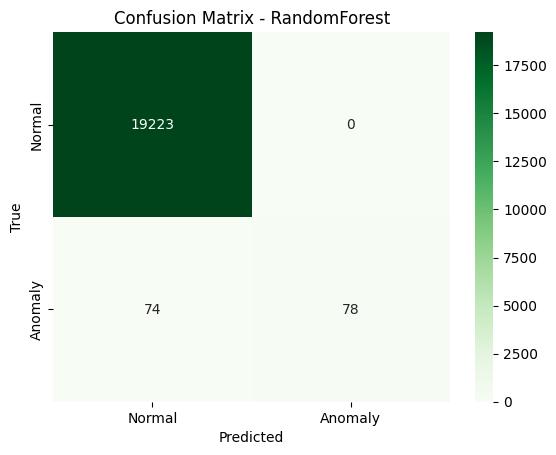

In [25]:
from sklearn.ensemble import RandomForestClassifier

# --- RandomForest Classifier ---
rf_clf = RandomForestClassifier(
    n_estimators=300,
    max_depth=10,
    class_weight="balanced",  # handles imbalance automatically
    random_state=42,
    n_jobs=-1
)

rf_clf.fit(X_train, y_train)

# --- Predictions ---
y_pred_rf = rf_clf.predict(X_test)

print("Total anomalies in train set:", y_train.sum())
print("Total anomalies in test set:", y_test.sum())

# --- Evaluation ---
print("Evaluation - RandomForest")
print("Precision:", precision_score(y_test, y_pred_rf))
print("Recall   :", recall_score(y_test, y_pred_rf))
print("F1 Score :", f1_score(y_test, y_pred_rf))
print("\nClassification Report:")
print(classification_report(y_test, y_pred_rf))

# --- Confusion Matrix ---
cm_rf = confusion_matrix(y_test, y_pred_rf)
sns.heatmap(cm_rf, annot=True, fmt="d", cmap="Greens",
            xticklabels=["Normal", "Anomaly"],
            yticklabels=["Normal", "Anomaly"])
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix - RandomForest")
plt.show()
